In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')

In [111]:
df = pd.read_csv('shopping_behavior_updated.csv')
df.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [109]:
print("Step 1: Basic feature preparation...")
frequency_mapping = {
    "Weekly": 52,
    "Fortnightly": 26,
    "Bi-Weekly": 24,
    "Monthly": 12,
    "Every 3 Months": 4,
    "Quarterly": 4,
    "Annually": 1
}
df["Purchase_Frequency"] = df["Frequency of Purchases"].map(frequency_mapping)

Step 1: Basic feature preparation...


In [63]:
print("Step 2: Advanced feature engineering...")

# RFM Base Features
df['Recency_Score'] = df['Previous Purchases']
df['Frequency_Score'] = df['Frequency_Value']
df['Monetary_Score'] = df['Purchase Amount (USD)']

# Log transform monetary values to handle skew
df['Log_Monetary'] = np.log1p(df['Purchase Amount (USD)'])

# Creating customer value score (weighted RFM combined score)
df['Customer_Value_Score'] = (
    df['Recency_Score'] / df['Recency_Score'].max() * 0.2 + 
    df['Frequency_Score'] / df['Frequency_Score'].max() * 0.3 + 
    df['Monetary_Score'] / df['Monetary_Score'].max() * 0.5
)

# Engagement metrics
df['Review_Score'] = df['Review Rating'] / df['Review Rating'].max()
df['Discount_User'] = df['Discount Applied'].map({'Yes': 1, 'No': 0})
df['Promo_User'] = df['Promo Code Used'].map({'Yes': 1, 'No': 0})
df['Subscription_Value'] = df['Subscription Status'].map({'Yes': 1, 'No': 0})


Step 2: Advanced feature engineering...


In [64]:
# Price sensitivity (ratio of discounts to purchases)
df['Price_Sensitivity'] = df['Discount_User'] / (df['Frequency_Value'] + 1)

# Create seasonality preference
season_dummies = pd.get_dummies(df['Season'], prefix='Season')
df = pd.concat([df, season_dummies], axis=1)

# Calculate winter to summer ratio (adding 1 to avoid division by zero)
if 'Season_Winter' in season_dummies.columns and 'Season_Summer' in season_dummies.columns:
    df['Winter_Summer_Ratio'] = (df['Season_Winter'] + 1) / (df['Season_Summer'] + 1)
else:
    # Handle if the columns are named differently
    winter_col = [col for col in season_dummies.columns if 'winter' in col.lower()]
    summer_col = [col for col in season_dummies.columns if 'summer' in col.lower()]
    
    if winter_col and summer_col:
        df['Winter_Summer_Ratio'] = (df[winter_col[0]] + 1) / (df[summer_col[0]] + 1)
    else:
        df['Winter_Summer_Ratio'] = 1  # Default if columns not found

# Size preference metrics
size_dummies = pd.get_dummies(df['Size'], prefix='Size')
df = pd.concat([df, size_dummies], axis=1)

# Payment method preference
payment_dummies = pd.get_dummies(df['Payment Method'], prefix='Payment')
df = pd.concat([df, payment_dummies], axis=1)

In [72]:
# Shipping preference metrics
shipping_dummies = pd.get_dummies(df['Shipping Type'], prefix='Shipping')
df = pd.concat([df, shipping_dummies], axis=1)

In [79]:
# Create shipping speed preference (higher for faster shipping)
df['Fast_Shipping_Preference'] = 0

# Print column names to inspect
shipping_columns = [col for col in df.columns if 'shipping' in col.lower()]
print("Available shipping columns:", shipping_columns)

Available shipping columns: ['Shipping Type', 'Shipping_2-Day Shipping', 'Shipping_Express', 'Shipping_Free Shipping', 'Shipping_Next Day Air', 'Shipping_Standard', 'Shipping_Store Pickup', 'Fast_Shipping_Preference', 'Shipping_2-Day Shipping', 'Shipping_Express', 'Shipping_Free Shipping', 'Shipping_Next Day Air', 'Shipping_Standard', 'Shipping_Store Pickup', 'Shipping_2-Day Shipping', 'Shipping_Express', 'Shipping_Free Shipping', 'Shipping_Next Day Air', 'Shipping_Standard', 'Shipping_Store Pickup', 'Shipping_2-Day Shipping', 'Shipping_Express', 'Shipping_Free Shipping', 'Shipping_Next Day Air', 'Shipping_Standard', 'Shipping_Store Pickup', 'Shipping_2-Day Shipping', 'Shipping_Express', 'Shipping_Free Shipping', 'Shipping_Next Day Air', 'Shipping_Standard', 'Shipping_Store Pickup', 'Shipping_2-Day Shipping', 'Shipping_Express', 'Shipping_Free Shipping', 'Shipping_Next Day Air', 'Shipping_Standard', 'Shipping_Store Pickup', 'Shipping_2-Day Shipping', 'Shipping_Express', 'Shipping_Free 

In [80]:
# Create product category metrics
category_dummies = pd.get_dummies(df['Category'], prefix='Category')
df = pd.concat([df, category_dummies], axis=1)

# Create behavioral segments
df['High_Spender'] = (df['Purchase Amount (USD)'] > df['Purchase Amount (USD)'].quantile(0.75)).astype(int)
df['Frequent_Buyer'] = (df['Frequency_Value'] > df['Frequency_Value'].quantile(0.75)).astype(int)
df['Loyal_Customer'] = (df['Previous Purchases'] > df['Previous Purchases'].quantile(0.75)).astype(int)
df['Premium_Shipper'] = df['Fast_Shipping_Preference'].apply(lambda x: 1 if x > 0 else 0)


In [82]:
# Polynomial features for key metrics
df['Frequency_Squared'] = df['Frequency_Value'] ** 2
df['Monetary_Squared'] = df['Purchase Amount (USD)'] ** 2
df['Recency_Squared'] = df['Previous Purchases'] ** 2

# Interaction terms
df['Frequency_Monetary'] = df['Frequency_Value'] * df['Purchase Amount (USD)']
df['Recency_Frequency'] = df['Previous Purchases'] * df['Frequency_Value']

# Specialized Feature: Convert review rating to z-score to find enthusiast customers
df['Review_Z_Score'] = (df['Review Rating'] - df['Review Rating'].mean()) / df['Review Rating'].std()
df['Enthusiast_Customer'] = (df['Review_Z_Score'] > 1).astype(int)


In [85]:
# Binning features with duplicates parameter
df['Spending_Bin'] = pd.qcut(df['Purchase Amount (USD)'], 5, labels=False, duplicates='drop')
df['Frequency_Bin'] = pd.qcut(df['Frequency_Value'], 5, labels=False, duplicates='drop')
df['Recency_Bin'] = pd.qcut(df['Previous Purchases'], 5, labels=False, duplicates='drop')

In [88]:
# Manual RFM scoring with defined bins
frequency_bins = [0, 2, 6, 12, 26, 52]
frequency_labels = [1, 2, 3, 4, 5]
df['F_Score'] = pd.cut(df['Frequency_Value'], bins=frequency_bins, labels=frequency_labels).astype(int)

In [89]:
# Specialized Feature: Deal hunter (high discount sensitivity, low overall spend)
df['Deal_Hunter'] = ((df['Discount_User'] == 1) & 
                    (df['Promo_User'] == 1) & 
                    (df['Spending_Bin'] < 3)).astype(int)


In [90]:
# Create text embeddings
print("Step 3: Creating text embeddings...")
model = SentenceTransformer('all-MiniLM-L6-v2')

# Create rich customer profile text
df['Customer_Profile'] = df.apply(
    lambda row: f"{row['Gender']} {row['Age']} {row['Category']} {row['Item Purchased']} {row['Color']} {row['Season']} {row['Size']}", 
    axis=1
)
customer_embeddings = model.encode(df['Customer_Profile'].tolist())


Step 3: Creating text embeddings...


In [91]:
# Define features for clustering
print("Step 4: Preparing final feature set...")
# Core numerical features for clustering
numerical_features = [
    'Age', 'Purchase Amount (USD)', 'Log_Monetary', 'Previous Purchases',
    'Frequency_Value', 'Review_Rating', 'Customer_Value_Score', 'Price_Sensitivity',
    'Fast_Shipping_Preference', 'Discount_User', 'Promo_User', 'Subscription_Value',
    'High_Spender', 'Frequent_Buyer', 'Loyal_Customer', 'Winter_Summer_Ratio',
    'Frequency_Squared', 'Recency_Frequency', 'Frequency_Monetary', 'RFM_Score',
    'Enthusiast_Customer', 'Deal_Hunter'
]

# Check if all features exist in dataframe
numerical_features = [feat for feat in numerical_features if feat in df.columns]


Step 4: Preparing final feature set...


In [92]:
# Standardize features
print("Step 5: Standardizing features...")
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numerical_features])

# Apply PCA to embeddings
print("Step 6: Reducing embedding dimensions...")
pca = PCA(n_components=15, random_state=42)
embeddings_reduced = pca.fit_transform(customer_embeddings)
print(f"Explained variance by PCA: {pca.explained_variance_ratio_.sum() * 100:.2f}%")


Step 5: Standardizing features...
Step 6: Reducing embedding dimensions...
Explained variance by PCA: 62.17%


In [93]:
# Combine numerical features with embeddings
print("Step 7: Combining features...")
X_combined = np.hstack([df_scaled, embeddings_reduced])

# Try UMAP for dimensionality reduction (if installed)
try:
    import umap
    reducer = umap.UMAP(n_components=10, random_state=42)
    X_umap = reducer.fit_transform(X_combined)
    print("UMAP dimensionality reduction completed.")
    # We'll use this for one of our clustering approaches
except ImportError:
    print("UMAP not installed, skipping this step.")
    X_umap = X_combined

Step 7: Combining features...
UMAP dimensionality reduction completed.


In [94]:
# Determine optimal number of clusters using silhouette analysis
print("Step 9: Finding optimal number of clusters...")
silhouette_scores = []
davies_bouldin_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_combined)
    silhouette_scores.append(silhouette_score(X_combined, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_combined, labels))

# Plot evaluation metrics to find optimal k
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(k_range, silhouette_scores, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by Cluster Count')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, davies_bouldin_scores, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score by Cluster Count (lower is better)')
plt.grid(True)
plt.tight_layout()
plt.savefig('cluster_evaluation_metrics.png')
plt.close()

# Choose optimal k based on silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k} (Silhouette Score: {max(silhouette_scores):.4f})")


Step 9: Finding optimal number of clusters...
Optimal number of clusters: 2 (Silhouette Score: 0.3125)


In [95]:
# Apply multiple clustering approaches
print("Step 10: Applying multiple clustering methods...")

# K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(X_combined)
kmeans_silhouette = silhouette_score(X_combined, df['KMeans_Cluster'])
print(f"K-Means Silhouette Score: {kmeans_silhouette:.4f}")

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
df['GMM_Cluster'] = gmm.fit_predict(X_combined)
gmm_silhouette = silhouette_score(X_combined, df['GMM_Cluster'])
print(f"GMM Silhouette Score: {gmm_silhouette:.4f}")

# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=optimal_k)
df['Agglomerative_Cluster'] = agg.fit_predict(X_combined)
agg_silhouette = silhouette_score(X_combined, df['Agglomerative_Cluster'])
print(f"Agglomerative Clustering Silhouette Score: {agg_silhouette:.4f}")

# Try DBSCAN with automatic epsilon
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_combined)
distances, indices = nbrs.kneighbors(X_combined)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
knee_locator = np.diff(distances)
knee_idx = np.argmax(knee_locator) + 1
eps = distances[knee_idx]

dbscan = DBSCAN(eps=eps, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_combined)
# Filter out noise points (labeled as -1) for silhouette calculation
dbscan_filtered = df[df['DBSCAN_Cluster'] != -1]
if len(dbscan_filtered) > 1 and len(np.unique(dbscan_filtered['DBSCAN_Cluster'])) > 1:
    dbscan_silhouette = silhouette_score(
        X_combined[df['DBSCAN_Cluster'] != -1], 
        df.loc[df['DBSCAN_Cluster'] != -1, 'DBSCAN_Cluster']
    )
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.4f}")
    print(f"DBSCAN identified {len(np.unique(df['DBSCAN_Cluster']))-1} clusters and {(df['DBSCAN_Cluster'] == -1).sum()} noise points")
else:
    print("DBSCAN couldn't identify proper clusters or too many noise points")
    dbscan_silhouette = 0

# K-Means on UMAP-reduced data (if UMAP is available)
if 'X_umap' in locals():
    kmeans_umap = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df['KMeans_UMAP_Cluster'] = kmeans_umap.fit_predict(X_umap)
    kmeans_umap_silhouette = silhouette_score(X_umap, df['KMeans_UMAP_Cluster'])
    print(f"K-Means on UMAP Silhouette Score: {kmeans_umap_silhouette:.4f}")


Step 10: Applying multiple clustering methods...
K-Means Silhouette Score: 0.3125
GMM Silhouette Score: 0.3125
Agglomerative Clustering Silhouette Score: 0.3125
DBSCAN Silhouette Score: 0.3125
DBSCAN identified 1 clusters and 0 noise points
K-Means on UMAP Silhouette Score: 0.2914


In [96]:
# Select the best clustering method
print("Step 11: Selecting best clustering method...")
clustering_methods = {
    'K-Means': kmeans_silhouette,
    'GMM': gmm_silhouette,
    'Agglomerative': agg_silhouette,
    'DBSCAN': dbscan_silhouette
}

if 'X_umap' in locals():
    clustering_methods['K-Means UMAP'] = kmeans_umap_silhouette

best_method = max(clustering_methods, key=clustering_methods.get)
best_score = clustering_methods[best_method]
print(f"Best clustering method: {best_method} (Silhouette Score: {best_score:.4f})")

# Use the best clustering result
if best_method == 'K-Means':
    df['Cluster'] = df['KMeans_Cluster']
elif best_method == 'GMM':
    df['Cluster'] = df['GMM_Cluster']
elif best_method == 'Agglomerative':
    df['Cluster'] = df['Agglomerative_Cluster']
elif best_method == 'DBSCAN':
    df['Cluster'] = df['DBSCAN_Cluster']
elif best_method == 'K-Means UMAP':
    df['Cluster'] = df['KMeans_UMAP_Cluster']

Step 11: Selecting best clustering method...
Best clustering method: K-Means (Silhouette Score: 0.3125)


In [97]:
# Analyze final clusters
print("Step 12: Analyzing final clusters...")
cluster_sizes = df['Cluster'].value_counts().sort_index()
print("\nCluster sizes:")
print(cluster_sizes)


Step 12: Analyzing final clusters...

Cluster sizes:
Cluster
0     539
1    3361
Name: count, dtype: int64


In [100]:
# Profile clusters
print("\nStep 13: Profiling clusters...")
profile_features = [
    'Age', 'Purchase Amount (USD)', 'Previous Purchases', 'Frequency_Value', 
    'Customer_Value_Score', 'Discount_User', 'Promo_User', 'Subscription_Value'
]

# Check which features actually exist in the dataframe
available_features = [feature for feature in profile_features if feature in df.columns]
print(f"Available profile features: {available_features}")

# Use only the available features
cluster_profiles = df.groupby('Cluster')[available_features].mean()
print("\nCluster profiles:")
print(cluster_profiles)


Step 13: Profiling clusters...
Available profile features: ['Age', 'Purchase Amount (USD)', 'Previous Purchases', 'Frequency_Value', 'Customer_Value_Score', 'Discount_User', 'Promo_User', 'Subscription_Value']

Cluster profiles:
               Age  Purchase Amount (USD)  Previous Purchases  \
Cluster                                                         
0        44.649351              58.972171           25.771800   
1        43.975305              59.891401           25.284142   

         Frequency_Value  Customer_Value_Score  Discount_User  Promo_User  \
Cluster                                                                     
0               52.00000              0.697948       0.434137    0.434137   
1               11.60845              0.467565       0.429337    0.429337   

         Subscription_Value  
Cluster                      
0                  0.291280  
1                  0.266587  


In [101]:
# Visualize cluster profiles
print("Step 14: Creating visualization...")
plt.figure(figsize=(14, 8))
sns.heatmap(cluster_profiles, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Customer Segment Profiles (Silhouette Score: {best_score:.4f})")
plt.tight_layout()
plt.savefig('cluster_profiles_heatmap.png')
plt.close()

Step 14: Creating visualization...


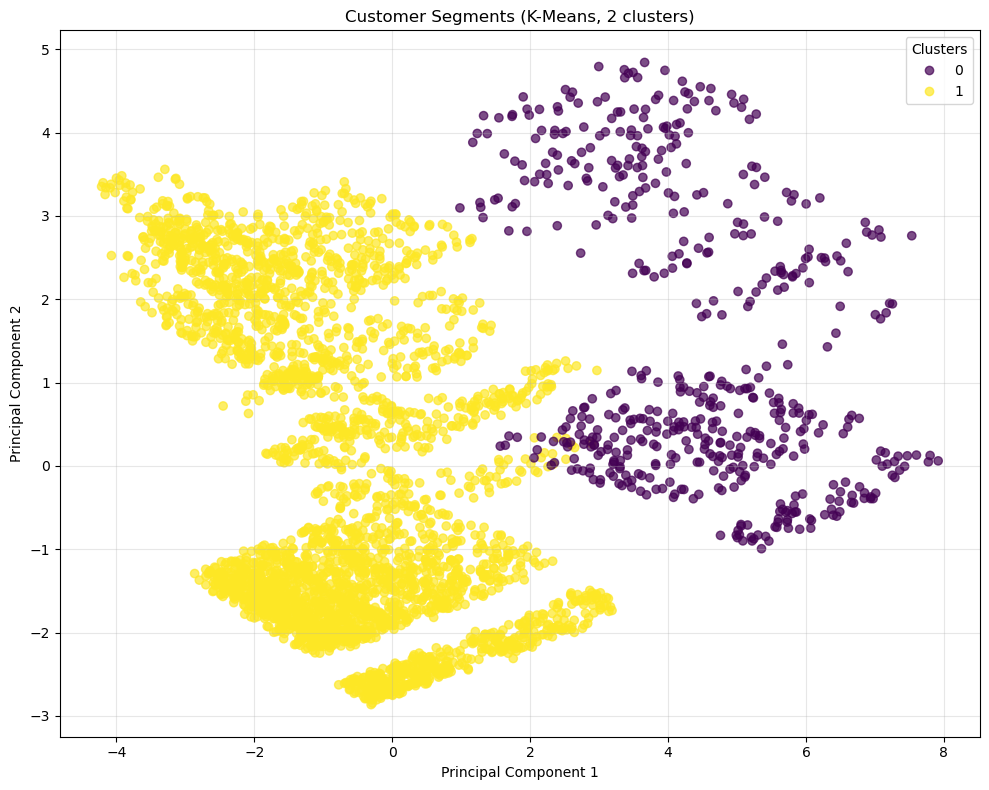

In [103]:
# Visualize clusters in 2D
pca_viz = PCA(n_components=2, random_state=42)
X_pca = pca_viz.fit_transform(X_combined)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"Customer Segments ({best_method}, {optimal_k} clusters)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [107]:
def summarize_cluster(cluster_num):
    cluster_data = df[df['Cluster'] == cluster_num]
    cluster_size = len(cluster_data)
    cluster_pct = cluster_size / len(df) * 100
    
    # Spending patterns
    avg_spend = cluster_data['Purchase Amount (USD)'].mean()
    avg_frequency = cluster_data['Frequency_Value'].mean()
    avg_previous = cluster_data['Previous Purchases'].mean()
    
    # Check if RFM_Score exists
    if 'RFM_Score' in df.columns:
        avg_rfm = cluster_data['RFM_Score'].mean()
    else:
        avg_rfm = "N/A"  # Or calculate it on the fly if needed
    
    # Demographics
    avg_age = cluster_data['Age'].mean()
    gender_dist = cluster_data['Gender'].value_counts(normalize=True)
    
    # Product preferences
    top_categories = cluster_data['Category'].value_counts().nlargest(2)
    top_items = cluster_data['Item Purchased'].value_counts().nlargest(2)
    top_colors = cluster_data['Color'].value_counts().nlargest(2)
    top_seasons = cluster_data['Season'].value_counts().nlargest(2)
    
    # Purchase behavior
    discount_rate = cluster_data['Discount_User'].mean() * 100
    promo_rate = cluster_data['Promo_User'].mean() * 100
    subscription_rate = cluster_data['Subscription_Value'].mean() * 100
    
    # Output cluster summary
    print(f"\n=== CLUSTER {cluster_num} PROFILE ===")
    print(f"Size: {cluster_size} customers ({cluster_pct:.1f}% of total)")
    print(f"\nSPENDING BEHAVIOR:")
    print(f"• Average purchase: ${avg_spend:.2f}")
    print(f"• Purchase frequency: {avg_frequency:.1f} times per year")
    print(f"• Previous purchases: {avg_previous:.1f}")
    
    if 'RFM_Score' in df.columns:
        print(f"• RFM score: {avg_rfm:.1f}/15")
    
    # ... rest of the function remains the same ...
    
    # Add any key distinctive features for this cluster
    print(f"\nDISTINCTIVE CHARACTERISTICS:")
    
    # Compare to overall average and identify distinguishing features
    all_features = [
        'Age', 'Purchase Amount (USD)', 'Previous Purchases', 'Frequency_Value', 
        'Discount_User', 'Promo_User', 'Subscription_Value'
    ]
    
    if 'High_Spender' in df.columns:
        all_features.append('High_Spender')
    if 'Frequent_Buyer' in df.columns:
        all_features.append('Frequent_Buyer')
    if 'Loyal_Customer' in df.columns:
        all_features.append('Loyal_Customer')
    if 'Deal_Hunter' in df.columns:
        all_features.append('Deal_Hunter')
    if 'Enthusiast_Customer' in df.columns:
        all_features.append('Enthusiast_Customer')
    
    for feature in all_features:
        if feature in df.columns:
            cluster_avg = cluster_data[feature].mean()
            overall_avg = df[feature].mean()
            pct_diff = ((cluster_avg - overall_avg) / overall_avg) * 100
            
            if abs(pct_diff) > 20:  # Only show features with significant difference
                direction = "higher" if pct_diff > 0 else "lower"
                print(f"• {feature.replace('_', ' ').title()}: {abs(pct_diff):.1f}% {direction} than average")
    
    return cluster_data

In [108]:
# Create marketing recommendations for each cluster
print("\nStep 17: Marketing recommendations...")

# Extract unique clusters
unique_clusters = df['Cluster'].unique()

for cluster in sorted(unique_clusters):
    if cluster == -1 and best_method == 'DBSCAN':
        print("\n=== MARKETING RECOMMENDATIONS FOR NOISE POINTS ===")
        print("• Consider individual analysis or exclude from mass campaigns")
        print("• Monitor for potential fraud or unusual behavior")
        continue
        
    cluster_data = df[df['Cluster'] == cluster]
    
    print(f"\n=== MARKETING RECOMMENDATIONS FOR CLUSTER {cluster} ===")
    
    # High value customers
    if cluster_data['Customer_Value_Score'].mean() > df['Customer_Value_Score'].mean():
        print("• VIP Treatment Strategy:")
        print("  - Exclusive early access to new products")
        print("  - Premium loyalty program with special benefits")
        print("  - Personal shopping assistance")
    
    # Price sensitive customers
    if cluster_data['Price_Sensitivity'].mean() > df['Price_Sensitivity'].mean():
        print("• Discount-Focused Strategy:")
        print("  - Regular promotions and flash sales")
        print("  - Quantity discounts and bundle offers")
        print("  - Value-focused messaging highlighting savings")
    
    # Frequent buyers
    if cluster_data['Frequency_Value'].mean() > df['Frequency_Value'].mean():
        print("• Retention Strategy:")
        print("  - Subscription service or auto-replenishment options")
        print("  - Loyalty points with tiered rewards")
        print("  - Regular engagement through personalized content")
    
    # New or low engagement customers
    if cluster_data['Previous Purchases'].mean() < df['Previous Purchases'].mean():
        print("• Acquisition/Activation Strategy:")
        print("  - First-time buyer incentives")
        print("  - Educational content about product benefits")
        print("  - Simplified purchase journey and strong onboarding")
    
    # Product recommendations based on preferences
    top_categories = cluster_data['Category'].value_counts().index[:2]
    top_seasons = cluster_data['Season'].value_counts().index[:2]
    
    print(f"• Product Recommendations:")
    for category in top_categories:
        for season in top_seasons:
            print(f"  - {season} {category.lower()} items")
    
    # Channel and timing recommendations
    if cluster_data['Fast_Shipping_Preference'].mean() > df['Fast_Shipping_Preference'].mean():
        print("• Channel & Timing:")
        print("  - Emphasize quick delivery options")
        print("  - Last-minute shopping campaigns")
    else:
        print("• Channel & Timing:")
        print("  - Focus on quality and selection rather than speed")
        print("  - Early seasonal promotions with standard shipping")


Step 17: Marketing recommendations...

=== MARKETING RECOMMENDATIONS FOR CLUSTER 0 ===
• VIP Treatment Strategy:
  - Exclusive early access to new products
  - Premium loyalty program with special benefits
  - Personal shopping assistance
• Retention Strategy:
  - Subscription service or auto-replenishment options
  - Loyalty points with tiered rewards
  - Regular engagement through personalized content
• Product Recommendations:
  - Winter clothing items
  - Spring clothing items
  - Winter accessories items
  - Spring accessories items
• Channel & Timing:
  - Focus on quality and selection rather than speed
  - Early seasonal promotions with standard shipping

=== MARKETING RECOMMENDATIONS FOR CLUSTER 1 ===
• Discount-Focused Strategy:
  - Regular promotions and flash sales
  - Quantity discounts and bundle offers
  - Value-focused messaging highlighting savings
• Acquisition/Activation Strategy:
  - First-time buyer incentives
  - Educational content about product benefits
  - Simp